# Problem 1 (100 points)

Many physics systems are governed by the following type of partial differential equations (PDEs)

$$
F \left( t, \mathbf{r}, u, u_t, u_{tt}, \nabla_{\mathbf{r}} \ u, \nabla^2_{\mathbf{r}} \ u \right) = 0 , \ \forall \ t \in \left[ 0 , T \right], \ \mathbf{r} \in \mathcal S
$$

where

* $t \in \Bbb R$: Time.
* $\mathbf{r} \in \Bbb R^3$: Position.
* $u \left( t, \mathbf{r} \right) \in \Bbb R$: A function of $t$ and $\mathbf{r}$ that is differentiable.
* $u_t$: $\frac{\partial u}{\partial t}$.
* $u_{tt}$: $\frac{\partial^2 u}{\partial t^2}$.
* $\mathcal S$: A convex set in $\Bbb R^3$.

For such a physics system, if we know

1. **Initial condition (IC)**
    * $u \left( 0, \mathbf{r} \right)$ for all $\mathbf{r} \in \mathcal S$.
    * $u_t \left( 0, \mathbf{r} \right)$ for all $\mathbf{r} \in \mathcal S$ (This term is required if $u_{tt}$ appears in $F$. Otherwise, it is not needed.).
2. **Boundary condition (BC)**
   * $u \left( t, \mathbf{r} \right)$ for all $t \in \left[ 0 , T \right]$ and $\mathbf{r} \in \text{Boundary} \left( \mathcal S \right)$.

Then the value of $u \left( t , \mathbf{r} \right)$ for any $t \in \left[ 0 , T \right]$ and $\mathbf{r} \in \mathcal S$ is uniquely determined.

However, many such systems do not admit closed-form solutions. The canonical approach of discretizing a PDE to find numeric solutions has many limitations.

To avoid those challenges, in this problem, you are asked to use the deep neural network approach to solve a physics-informed PDE, hereafter called as **Physics-Informed Neural Network (PINN)**.

In this problem, let us consider the following specific **1-dim thermal system**:

* A 1-dim rod with unit length.
* The thermal diffusivity is $\alpha > 0$.
* Two endpoints of the rod are connected to two heat reservoirs whose temperatures are constant and normalized as 0.
* At time $t = 0$, the temperature distribution on the rod follows a sinusoidal pattern.

Denote by $u \left( t, x \right)$ the temperature at time $t$ on position $x$ in the rod.

Thus, $u \left( t, x \right)$ satisfies:

1. **PDE**

   $$
   u_t - \alpha \ u_{xx} = 0 , \ x \in \left[ 0, 1 \right] , \ t \in \left[ 0, 1 \right] ,
   $$

   where
   * $u_t$: $\frac{\partial u}{\partial t}$.
   * $u_x$: $\frac{\partial u}{\partial x}$.
   * $u_{xx}$: $\frac{\partial^2 u}{\partial x^2}$.

3. **IC**

   $$
   u \left( 0, x \right) = \sin  \left( \pi x \right) , \ \forall \ x \in \left[ 0, 1 \right] .
   $$

4. **BC**

   $$
   u \left( t, 0 \right) = u \left( t, 1 \right) = 0 , \ \forall \ t \in \left[ 0, 1 \right] .
   $$

Before starting this problem, make sure to run the following code first **without any change**:

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

> WARNING !!!
> 
- Beyond importing libraries/modules/classes/functions in the preceding cell, you are **NOT allowed to import anything else for the following purposes**:
    - **As a part of your final solution.** For instance, if a problem asks you to build a model without using sklearn but you use it, then you will not earn points.
    - **Temporarily import something to assist you to get a solution.** For instance, if a problem asks you to manually compute eigenvalues but you temporarily use `np.linalg.eig` to get an answer and then delete your code, then you violate the rule.

    **Rule of thumb:** Each part has its particular purpose to intentionally test you something. Do not attempt to find a shortcut to circumvent the rule.

## Part 1 (10 points, non-coding task)

**Prove that the solution to the above PDE, IC, and BC takes the following form:**

$$
u \left( t, x \right) = e^{- \alpha \pi^2 t} \sin \left( \pi x \right) .
$$

* Reasoning is required.
* This part is used for the purpose of verifying the correctness of our subsequent PINN solution.

\#\#\# WRITE YOUR SOLUTION HERE ###

We have

$$
\begin{aligned}
u_t &= -\alpha\pi^2 e^{-\alpha\pi^2t} \sin\left({\pi x}\right) \\
    &= -\alpha\pi^2 u \left( t, x \right)
\end{aligned}
$$

and

$$
\begin{aligned}
u_{xx} &= \frac{\partial}{\partial x} \left(\pi e^{-\alpha\pi^2t} \cos\left(\pi x\right)\right) \\
       &= -\pi^2 e^{-\alpha\pi^2t} \sin\left({\pi x}\right) \\
       &= -\pi^2 u \left( t, x \right).
\end{aligned}
$$

Hence, the form satisfies the PDE $u_t - \alpha \ u_{xx} = 0$.

When $t=0$, $u \left( 0, x \right) = \sin\left({\pi x}\right)$. The form satisfies the IC.

When $x\in\{0,1\}$, $\sin\left(0\right)=0$ and $u \left( t, x \right) = 0$. The form satisfies the BC.


""" END OF THIS PART """

The high-level idea of PINN is as follows:

1. **(Neural network)** We design a neural network (functional mapping) $U \left( \cdot, \cdot \mid \mathbf{\theta} \right): \left[ 0 , 1 \right]^2 \rightarrow \Bbb R$, such that

   - $\theta$: learnable parameters in $U$.
   - Inputs are time $t$ and position $x$.
   - Output is the predicted temperature.

2. **(Training data)** To train $U$ (equivalently, to learn $\theta$), we use the following three groups of temporal-spacial data $(t,x)$:

   - **(Training data for PDE)** $(t,x)$ are randomly sampled from $[0,1]^2$. \
     Denote by $\mathcal D_{PDE}$ the set of these data points.
   - **(Training data for IC)** $(0,x)$ with $x$ that are evenly distributed on $[0,1]$. \
     Denote by $\mathcal D_{IC}$ the set of these data points.
   - **(Training data for BC)** $(t,0)$ and $(t,1)$ with $t$ that are evenly distributed on $[0,1]$. \
     Denote by $\mathcal D_{BC}$ the set of these data points.

3. **(Loss function in training)** $$L_{total} = L_{PDE} + L_{IC} + L_{BC} ,$$ where

   - Residual loss in PDE: $$L_{PDE} = \frac{1}{| \mathcal D_{PDE} |} \sum_{\left( t, x \right) \in \mathcal D_{PDE}} \left( \frac{\partial U \left( t, x \mid \mathbf{\theta} \right)}{\partial t} - \alpha \frac{\partial^2 U \left( t, x \mid \mathbf{\theta} \right)}{\partial x^2} \right)^2 .$$
   - IC loss: $$L_{IC} = \frac{1}{| \mathcal D_{IC} |} \sum_{\left( t, x \right) \in \mathcal D_{IC}} \left( U \left( t, x \mid \mathbf{\theta} \right) - u \left( t, x \right) \right)^2 .$$
   - BC loss: $$L_{BC} = \frac{1}{| \mathcal D_{BC} |} \sum_{\left( t, x \right) \in \mathcal D_{BC}} \left( U \left( t, x \mid \mathbf{\theta} \right) - u \left( t, x \right) \right)^2 .$$

## Part 2 (10 points, coding task)

In this part, you are asked to build a deep neural network that is used to output PDE solutions.

1. The class name is `HeatPINN`. \
   It subclasses `nn.Module`.

2. The model consists of the following layers that are sequentially connected: \
   (1) Fully connected layer with `out_features = 64` (you need to determine `in_features` taken from the input). \
   (2) Activation layer with tanh function. \
   (3) Fully connected layer with `in_features = 64` and `out_features = 64`. \
   (4) Activation layer with tanh function. \
   (5) Fully connected layer with `in_features = 64` (you need to determine `out_features` as the output of the entire model).

3. Construct a model who is an object of this class and is called as `model`.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [2]:
class HeatPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [3]:
model = HeatPINN()

""" END OF THIS PART """

## Part 3 (5 points, coding task)

Do the following tasks:

Let x be a tensor with shape `(N,2)`.

1. What is the number of dimensions of `model(x)`?
2. What is the shape of `model(x)`?
3. Explain the reasoning of your answers.

\#\#\# WRITE YOUR SOLUTION HERE ###

1. The dimension of `model(x)` is 2.
2. The shape of `model(x)` is `(N,1)`.
3. Each set of input gives an output of shape `(1,)`. There are `N` sets of them. Therefore, the output shape is `(N,1)`.

""" END OF THIS PART """

## Part 4 (10 points, coding task)

In this part, you are asked to create the dataset $\mathcal D_{PDE}$.

1. The dataset object is called `dataset_train_PDE`. It is in a class called `Dataset_PDE` that you need to build.
2. Class `Dataset_PDE` subclasses `Dataset`.
3. Each $\left( t, x \right) \in \mathcal D_{PDE}$ is randomly sampled from $[0,1]^2$.
4. Set $|\mathcal D_{PDE}| = 500$.
5. *Set `requires_grad = True`.*

\#\#\# WRITE YOUR SOLUTION HERE ###

In [4]:
class Dataset_PDE(Dataset):
    def __init__(self, size):
        self.data = torch.rand(size, 2, requires_grad=True)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
dataset_train_PDE = Dataset_PDE(500)

""" END OF THIS PART """

## Part 5 (5 points, coding task)

In this part, you are asked to define a `Dataloader` object called `dataloader_PDE`:

1. `dataset = dataset_train_PDE`
2. `batch_size = 32`
3. `shuffle = True`

\#\#\# WRITE YOUR SOLUTION HERE ###

In [6]:
dataloader_PDE = DataLoader(dataset_train_PDE, batch_size=32, shuffle=True)

""" END OF THIS PART """

## Part 6 (10 points, coding task)

In this part, you are asked to create the dataset $\mathcal D_{IC}$.

1. Define dataset $\mathcal D_{IC}$ in the way that for each $(t,x) \in\mathcal D_{IC}$, $t$ is fixed at 0 and $x$ is evenly sampled from $\left\{ 0, 0.01, 0.02, \cdots , 0.98, 0.99, 1 \right\}$. Therefore, $|\mathcal D_{IC}|= 101$.
2. The dataset shall be a tensor with name `dataset_train_IC` and shape `(101,2)`.
3. <del>Set `dataset_train_IC.requires_grad = True`.</del>
4. Print `dataset_train_IC.requires_grad` and `dataset_train_IC.shape`.
5. Define tensor `u_IC` to be the ground-truth functional values of all data in $\mathcal D_{IC}$ (You can find the formula from Part 1).
6. Set <del>`u_IC.requires_grad = True` and</del> `u_IC.shape = (101,1)`.
7. Print `u_IC.requires_grad` and `u_IC.shape`.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [7]:
dataset_train_IC = torch.vstack([torch.zeros(101), torch.arange(0, 1.01, 0.01)]).T

In [8]:
dataset_train_IC.requires_grad, dataset_train_IC.shape

(False, torch.Size([101, 2]))

In [9]:
u_IC = torch.sin(torch.pi * dataset_train_IC[:, 1]).reshape(-1, 1)

In [10]:
u_IC.requires_grad, u_IC.shape

(False, torch.Size([101, 1]))

""" END OF THIS PART """

## Part 7 (10 points, coding task)

In this part, you are asked to create the dataset $\mathcal D_{BC}$.

1. Define dataset $\mathcal D_{BC}$ in the way that for each $(t,x) \in\mathcal D_{BC}$, $x$ is either 0 or 1, and $t$ is evenly sampled from $\left\{ 0, 0.01, 0.02, \cdots , 0.98, 0.99, 1 \right\}$. Therefore, $|\mathcal D_{BC}|= 2 \cdot 101 = 202$.
2. The dataset shall be a tensor with name `dataset_train_BC` and shape `(202,2)`.
3. <del>Set `dataset_train_BC.requires_grad = True`.</del>
4. Print `dataset_train_BC.requires_grad` and `dataset_train_BC.shape`.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [11]:
tmp1 = torch.vstack([torch.arange(0, 1.01, 0.01), torch.zeros(101)]).T
tmp2 = torch.vstack([torch.arange(0, 1.01, 0.01), torch.ones(101)]).T

dataset_train_BC = torch.vstack([tmp1, tmp2])

In [12]:
dataset_train_BC.requires_grad, dataset_train_BC.shape

(False, torch.Size([202, 2]))

""" END OF THIS PART """

## Part 8 (5 points, coding task)

In this part, you are asked to configure your optimizer.

1. Define an optimizer object called `optimizer`.
2. Configure the optimization method as `Adam`.
3. Set the learning rate as `1e-3`.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

""" END OF THIS PART """

## Part 9 (10 points, coding task)

The purpose of this part is to guide you to learn using `torch.autograd.grad`.

For each given input $(t,x)$, we not only compute $U \left( t, x \mid \mathbf{\theta} \right)$ (output from the model), but also its 1st and 2nd order partial derivatives.

In PyTorch, these can be done by using `torch.autograd.grad`.

### Part 9.1

Consider the following function

$$
f \left( p, q \right) = p^2 + q^3 + p q^2 .
$$

**Do the following tasks at** $\left( p, q \right) = \left( 1, 2 \right)$:

1. Define tensors `p` and `q` that have values `1.0` and `2.0` (float data type), respectively, an identical shape `()` (that is, 0-dim), and `requires_grad = True`.
2. Compute tensor `f` according to the formula above.
3. Compute $\frac{\partial f \left( p, q \right)}{\partial p}$ by using
   ```python
   f_p = autograd.grad(f, p, create_graph=True)[0]
   ```
   Print `f_p`.
4. Compute $\frac{\partial f \left( p, q \right)}{\partial q}$ by using
   ```python
   f_q = autograd.grad(f, q, create_graph=True)[0]
   ```
   Print `f_q`.
5. Compute $\frac{\partial^2 f \left( p, q \right)}{\partial p^2}$ by using
   ```python
   f_pp = autograd.grad(f_p, p, create_graph=True)[0]
   ```
   Print `f_pp`.
6. Compute $\frac{\partial^2 f \left( p, q \right)}{\partial q^2}$ by using
   ```python
   f_qq = autograd.grad(f_q, q, create_graph=True)[0]
   ```
   Print `f_qq`.
7. Compute $\frac{\partial^2 f \left( p, q \right)}{\partial p \partial q}$ by using
   ```python
   f_pq = autograd.grad(f_p, q, create_graph=True)[0]
   ```
   Print `f_pq`.
8. Compute $\frac{\partial^3 f \left( p, q \right)}{\partial q^3}$ by using
   ```python
   f_qqq = autograd.grad(f_qq, q, create_graph=True)[0]
   ```
   Print `f_qqq`.

### Part 9.2

Consider the following function

$$
g \left( x \right) = x^2 .
$$

Let $x$ be a vector with values $0, 0.1, \cdots , 0.9, 1$.

**Do the following tasks.**

1. Generate `x` as a 1-dim tensor and set `x.requires_grad = True`.

2. Generate `g = x**2`. Thus, `g` has the same shape as `x`.

3. Define `g_x` to be an element-wise 1st-order derivative of function $g$ with respect to $x$. Thus, `g_x` has the same shape as `x`. \
   Write code to compute `g_x`. Print `g_x` and `g_x.shape`. \
   Hint: by using `autograd.grad(f, x, create_graph=True)[0]`, tensor `x` can be with any dimension, but tensor `f` must be with dimension 0. In this problem, tensor `g` is not with dimension 0. So you need to think about how to address this issue.

4. Define `g_xx` to be an element-wise 2nd-order derivative of function $g$ with respect to $x$. Thus, `g_xx` has the same shape as `x`. Write code to compute `g_xx`. Print it out `g_xx` and `g_xx.shape`.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [14]:
p, q = torch.tensor(1., requires_grad=True), torch.tensor(2., requires_grad=True)

In [15]:
f = p ** 2 + q ** 3 + p * q ** 2

In [16]:
f_p = autograd.grad(f, p, create_graph=True)[0]
f_p

tensor(6., grad_fn=<AddBackward0>)

In [17]:
f_q = autograd.grad(f, q, create_graph=True)[0]
f_q

tensor(16., grad_fn=<AddBackward0>)

In [18]:
f_pp = autograd.grad(f_p, p, create_graph=True)[0]
f_pp

tensor(2., grad_fn=<MulBackward0>)

In [19]:
f_qq = autograd.grad(f_q, q, create_graph=True)[0]
f_qq

tensor(14., grad_fn=<AddBackward0>)

In [20]:
f_pq = autograd.grad(f_p, q, create_graph=True)[0]
f_pq

tensor(4., grad_fn=<MulBackward0>)

In [21]:
f_qqq = autograd.grad(f_qq, q, create_graph=True)[0]
f_qqq

tensor(6., grad_fn=<AddBackward0>)

---

In [22]:
x = torch.arange(0, 1.1, 0.1)
x.requires_grad = True

In [23]:
g = x ** 2

In [24]:
# A not so good solution:
# g_x = torch.diag(torch.vstack([autograd.grad(g[i], x, create_graph=True)[0] for i in range(x.shape[0])]))
# A good one:
g_x = autograd.grad(torch.sum(g), x, create_graph=True)[0]
g_x, g_x.shape

(tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000, 1.2000, 1.4000, 1.6000,
         1.8000, 2.0000], grad_fn=<MulBackward0>),
 torch.Size([11]))

In [25]:
g_xx = autograd.grad(torch.sum(g_x), x, create_graph=True)[0]
g_xx, g_xx.shape

(tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], grad_fn=<MulBackward0>),
 torch.Size([11]))

""" END OF THIS PART """

## Part 10 (10 points, coding task)

This part asks you to do a mini-batch training of the model.

1. Set the parameter in the PDE `alpha = 0.1`. (This is not for learning. In PINN, we know the exact form of a PDE. We just need neural networks to help us solve it.)
2. Set the number of epochs as 1000.
3. Define
   ```python
   device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   ```
4. While iterating over epochs, use tqdm to track the progress:
   ```python
   for epoch in tqdm(range(num_epochs)):
   
   ```
5. In each epoch, \
   (1) Configure the model to the training mode. \
   (2) Iterate over all mini-batches of `dataset_train_PDE`. \
   (3) For each of the above mini-batches of the PDE dataset, while computing the total loss function, you also need to use **all** data in `dataset_train_IC` and `dataset_train_BC`. \
   (4) Do all these tasks on **GPU**.
6. In each epoch, after training over all mini-batches, if the epoch index is divisible by 100, do the following tasks: \
   (1) Configure the model to the evaluation mode. \
   (2) Compute the total loss over the entire three datasets: `dataset_train_PDE`, `dataset_train_IC`, `dataset_train_BC`. \
   (3) Print the epoch index, the residual loss from PDE, the IC loss, the BC loss, and the total loss. \
   (4) Do all these tasks on **CPU**.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [26]:
alpha = 0.1
num_epochs = 1000

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
def compute_loss(PDE_datapoints, device):
    with torch.enable_grad():
        U_PDE = model.to(device)(PDE_datapoints.to(device))
        dt, dx = autograd.grad(torch.sum(U_PDE), PDE_datapoints, create_graph=True)[0].unbind(dim=1)
        dxx = autograd.grad(torch.sum(dx), PDE_datapoints, create_graph=True)[0][:, 1]
    PDE_loss = nn.functional.mse_loss(dt, alpha * dxx)
    # This also works:
    # PDE_loss = torch.mean((dt - alpha * dxx) ** 2)

    U_IC = model.to(device)(dataset_train_IC.to(device))
    IC_loss = nn.functional.mse_loss(U_IC, u_IC.to(device))
    # This also works:
    # IC_loss = torch.mean((U_IC - u_IC.to(device)) ** 2)

    U_BC = model.to(device)(dataset_train_BC.to(device))
    BC_loss = nn.functional.mse_loss(U_BC, torch.zeros_like(U_BC, device=device))  # u_BC = 0
    # This also works:
    # BC_loss = torch.mean(U_BC ** 2)
    
    return PDE_loss, IC_loss, BC_loss, PDE_loss + IC_loss + BC_loss

In [29]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch_datapoints in dataloader_PDE:
        *_, total_loss = compute_loss(batch_datapoints, device)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            PDE_loss, IC_loss, BC_loss, total_loss = compute_loss(dataset_train_PDE.data, "cpu")
            PDE_loss, IC_loss, BC_loss, total_loss = PDE_loss.item(), IC_loss.item(), BC_loss.item(), total_loss.item()
        print(f"Epoch {epoch}: {PDE_loss=}, {IC_loss=}, {BC_loss=}, {total_loss=}.")

  0%|▏                                                                                | 2/1000 [00:00<04:56,  3.37it/s]

Epoch 0: PDE_loss=0.022400274872779846, IC_loss=0.16262602806091309, BC_loss=0.07752777636051178, total_loss=0.2625540792942047.


 10%|████████                                                                       | 102/1000 [00:16<02:21,  6.34it/s]

Epoch 100: PDE_loss=7.090953295119107e-05, IC_loss=4.4491171138361096e-05, BC_loss=5.046738442615606e-05, total_loss=0.00016586808487772942.


 20%|███████████████▉                                                               | 201/1000 [00:34<02:51,  4.65it/s]

Epoch 200: PDE_loss=2.185691482736729e-05, IC_loss=1.1921855502805556e-06, BC_loss=3.071525952691445e-06, total_loss=2.612062598927878e-05.


 30%|███████████████████████▊                                                       | 302/1000 [00:54<01:55,  6.05it/s]

Epoch 300: PDE_loss=1.646106284169946e-05, IC_loss=8.779680342740903e-07, BC_loss=1.9784840787906433e-06, total_loss=1.9317514670547098e-05.


 40%|███████████████████████████████▊                                               | 402/1000 [01:12<01:57,  5.11it/s]

Epoch 400: PDE_loss=1.8423124856781214e-05, IC_loss=3.697861757245846e-06, BC_loss=8.289780453196727e-06, total_loss=3.0410767067223787e-05.


 50%|███████████████████████████████████████▋                                       | 502/1000 [01:32<01:18,  6.37it/s]

Epoch 500: PDE_loss=6.7535297603171784e-06, IC_loss=1.3647972082253546e-05, BC_loss=1.3238910469226539e-05, total_loss=3.364041185704991e-05.


 60%|███████████████████████████████████████████████▍                               | 601/1000 [01:51<01:43,  3.86it/s]

Epoch 600: PDE_loss=1.1479741260700393e-05, IC_loss=2.577304769602051e-07, BC_loss=3.095814804510155e-07, total_loss=1.2047053132846486e-05.


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [02:10<00:57,  5.23it/s]

Epoch 700: PDE_loss=5.598188181465957e-06, IC_loss=6.152224523248151e-05, BC_loss=6.158152245916426e-05, total_loss=0.00012870195496361703.


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [02:26<00:31,  6.33it/s]

Epoch 800: PDE_loss=4.192526830593124e-06, IC_loss=8.082976705736655e-07, BC_loss=2.121328179782722e-06, total_loss=7.122152510419255e-06.


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [02:45<00:19,  4.99it/s]

Epoch 900: PDE_loss=1.004540354188066e-05, IC_loss=3.1065721941558877e-06, BC_loss=6.8718068177986424e-06, total_loss=2.0023782781208865e-05.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:04<00:00,  5.43it/s]


""" END OF THIS PART """

## Part 11 (5 points, non-coding task)

**Answer the following free-response question.**

- **In each epoch, while iterating over each mini-batch of `dataset_PDE`, why do we consider the entire data points in `dataset_IC` and `dataset_BC`, rather than also a mini-batch in these two datasets?**

To be specific, recall that the mini-batch size of `dataset_PDE` is 32. The sizes of `dataset_IC` and `dataset_BC` are 101 and 202, respectively.

Then in each iteration, the number of data points that we use to compute the total loss value is $32+101+202=335$.

Suppose we also do mini-batch on the IC and BC datasets with the same mini-batch size, say, 32. Then in each iteration, the number of data points that we use is $32+32+32=96$.

We adopt the former approach, not the latter approach. You need to explain why.

\#\#\# WRITE YOUR SOLUTION HERE ###

IC and BC are constraints. We need to enforce them every time during training.

""" END OF THIS PART """

## Part 12 (10 points, coding task)

**In this part, you are asked to do the following tasks to test the effectiveness of our PINN model.**

1. Generate a dataset $\left\{ \left( t , x \right) \in \left\{ 0, 0.01, \cdots, 1 \right\}^2 \right\}$. Save the dataset as a tensor with name `tx_test` and shape <del>`(101,2)`</del> `(10201,2)`.
2. For each data point, compute $u \left( t , x \right)$ whose formula is given in Part 1. Save the result as a tensor with name `u_test` and shape <del>`(101,2)`</del> `(10201,)`.
3. For each data point, use our trained PINN model to compute the predicted value $U \left( t, x \mid \mathbf{\theta} \right)$. Save the result as a tensor with name `U_test` and shape <del>`(101,2)`</del> `(10201,)`.
4. Print the mean squared error between `u_test` and `U_test`.
5. Generate two 2-dim scatter plots for $\left( t, x \right)$ by using the above data points.
   - In Figure 1, the value in each position is the ground-truth temperature $u \left( t , x \right)$.
   - In Figure 2, the value in each position is the predicted temperature $U \left( t, x \mid \mathbf{\theta} \right)$.
   - In each plot,
     - Set `c` as the values on those scattered positions.
     - Set `cmap='viridis'`.
     - Add `plt.colorbar(label='Value')`.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [30]:
range_ = torch.arange(0, 1.01, 0.01)

tx_test = torch.cartesian_prod(range_, range_)
tx_test.shape

torch.Size([10201, 2])

In [31]:
u_test = (torch.exp(-alpha * torch.pi ** 2 * tx_test[:, 0]) * torch.sin(torch.pi * tx_test[:, 1]))
u_test.shape

torch.Size([10201])

In [32]:
model.eval()
with torch.no_grad():
    U_test = model.to("cpu")(tx_test).reshape(-1)
U_test.shape

torch.Size([10201])

In [33]:
nn.functional.mse_loss(u_test, U_test).item()

3.94449925806839e-05

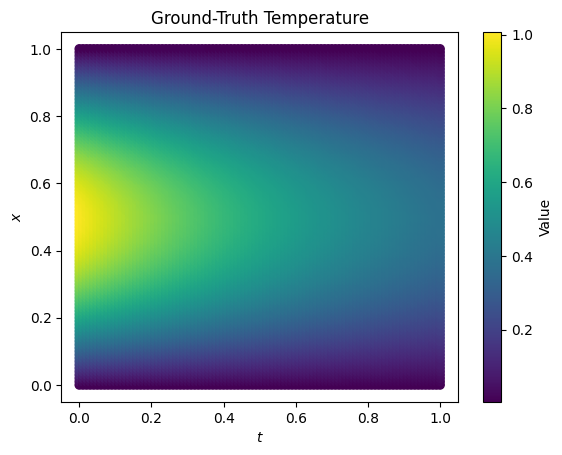

In [34]:
plt.scatter(*torch.unbind(tx_test, dim=1), c=U_test, cmap='viridis')
plt.title("Ground-Truth Temperature")
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.colorbar(label='Value');

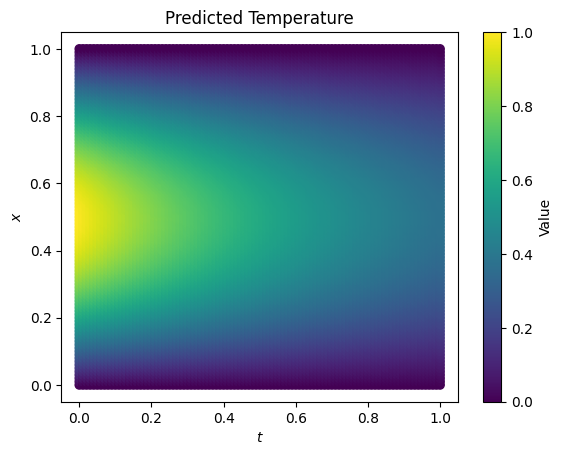

In [35]:
plt.scatter(*torch.unbind(tx_test, dim=1), c=u_test, cmap='viridis')
plt.title("Predicted Temperature")
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.colorbar(label='Value');

""" END OF THIS PART """